In [1]:
%matplotlib
import torch
import torch.nn.functional as F

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj, add_self_loops

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as spio

import os
os.chdir("../")

import sys
sys.path.append('../scripts')

# loading scripts from here
from evaluation import accuracy
from evaluation import areaundercurve
from evaluation import average_precision_score_computation

"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/layers.py

Author: Thomas kipf
Paper: 
Semi-Supervised Classification with Graph Convolutional Networks
https://arxiv.org/abs/1609.02907
"""

from GCNConv import GraphConvolution

Using matplotlib backend: agg


In [2]:
"""
This is an implementation from:
https://github.com/tkipf/pygcn/blob/master/pygcn/models.py

Model and training settings are from:
https://github.com/tkipf/pygcn/blob/master/pygcn/train.py
which is the same as reported from the paper.

Author: Thomas kipf
"""
class Net(torch.nn.Module):
    def __init__(self, in_channel, out_channel, data):
        super(Net, self).__init__()

        self.gc1 = GraphConvolution(in_channel, 16)
        self.gc2 = GraphConvolution(16, out_channel)
        
        injection = torch.ones_like(data.adj) * 0.01
        injection = torch.abs(injection)
        self.injection = torch.nn.Parameter(
            injection, 
            requires_grad=True
        )

    def forward(self, data):
        x, adj = data.x, data.adj
        
        # link injection
#         injection = F.relu(self.injection)
        injection = F.leaky_relu(self.injection)
        adj = adj + injection
        adj = torch.clamp(adj, 0, 1)
        
        # forward passing
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.gc2(x, adj)
        return F.log_softmax(x, dim=1)

In [3]:
from tqdm import tqdm

NUMEPOCHS = 10000
early_stop_win_size = 100
earliest_stop = 5000
tolerance = 1.00

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data
name = 'Cora'
dataset = Planetoid('../datasets/'+ name, name=name)

in_dim = dataset.num_node_features
out_dim = dataset.num_classes

data = dataset.data
# data.adj = to_dense_adj(add_self_loops(data.edge_index)[0])[0]
data.adj = torch.zeros(data.x.size(0), data.x.size(0))
data = dataset.data.to(device)

# compile model
model = Net(
    in_dim,
    out_dim,
    data
).to(device)

# optimizer = torch.optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.01)
optimizer = torch.optim.Adamax(model.parameters(), weight_decay=1e-8)

In [4]:
# get the initial injection
injection_init = model.injection.detach().cpu().numpy()

In [19]:
# record accuracy
train_acc = np.zeros(NUMEPOCHS)
val_acc = np.zeros(NUMEPOCHS)
test_acc = np.zeros(NUMEPOCHS)

# training start
model.train()

for epoch in range(NUMEPOCHS):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    # record the accuracy
    train_acc[epoch] = accuracy(model, data, 'train')
    val_acc[epoch] = accuracy(model, data, 'val')
    test_acc[epoch] = accuracy(model, data, 'test')
    
    # early stopping
    if epoch > max(2 * early_stop_win_size, earliest_stop):
#         prev_start = epoch - 2 * early_stop_win_size
#         prev_end = epoch - early_stop_win_size
        current_start = epoch - early_stop_win_size
        current_end = epoch
        
        val_acc_current = np.mean(val_acc[current_start: current_end])
#         val_acc_previous = np.mean(val_acc[prev_start: prev_end])
        
#         if val_acc_current < val_acc_previous - tolerance:
        if val_acc_current < np.max(val_acc) - tolerance:
            train_acc = train_acc[:epoch]
            val_acc = val_acc[:epoch]
            test_acc = test_acc[:epoch]
            print('Moving Average Early stopping at %d-th epoch' % epoch)
            print(
                'Previous validation average accuracy for %d-th to %d-th epoch: %f' % \
                (prev_start, prev_end, val_acc_previous)
            )
            print(
                'Current validation average accuracy for %d-th to %d-th epoch: %f' % \
                (current_start, current_end, val_acc_current)
            )
            break
    if epoch % 1000 == 0:
        print(
            epoch, 
            'training acc =', train_acc[epoch], 
            'validation acc =', val_acc[epoch], 
            ', loss =', loss.item()
        )

0 training acc = 0.9785714285714285 validation acc = 0.292 , loss = 3.9897618293762207
1000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
2000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
3000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
4000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
5000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
6000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
7000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
8000 training acc = 1.0 validation acc = 0.058 , loss = 0.0
9000 training acc = 1.0 validation acc = 0.058 , loss = 0.0


In [6]:
# get the initial injection
injection_final = F.relu(model.injection.detach()).cpu().numpy()

In [7]:
print('Initial injection = \n', injection_init)
print('\nSum inital = %d\n' % np.sum(injection_init))
print('Final injection = \n', injection_final)
print('\nSum final = %d\n' % np.sum(injection_final))

Initial injection = 
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]

Sum inital = 73333

Final injection = 
 [[0.00306438 0.         0.         ... 0.0059259  0.00601154 0.00525029]
 [0.00259529 0.         0.         ... 0.         0.00721286 0.        ]
 [0.00277693 0.         0.         ... 0.         0.00698741 0.        ]
 ...
 [0.         0.00393558 0.         ... 0.00532635 0.00382982 0.00806108]
 [0.00076833 0.00022553 0.         ... 0.         0.00270252 0.00268499]
 [0.01141115 0.00378287 0.         ... 0.00501925 0.00549314 0.00904689]]

Sum final = 60280



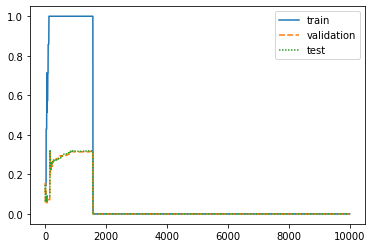

In [8]:
df_acc = pd.DataFrame({
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

sns.lineplot(data=df_acc)
plt.show()

In [ ]:
spio.savemat('../variables/CiteSeer/SAGEConv.mat',{
    'train': train_acc,
    'validation': val_acc,
    'test': test_acc
})

In [9]:
print('Train Accuracy: {:.4f}'.format(accuracy(model, data, 'train')))
print('Validation Accuracy: {:.4f}'.format(accuracy(model, data, 'val')))
print('Test Accuracy: {:.4f}'.format(accuracy(model, data, 'test')))

Train Accuracy: 1.0000
Validation Accuracy: 0.3160
Test Accuracy: 0.3190


In [10]:
print('Test AUC: {:.4f}'.format(areaundercurve(model,data,'test')))

Test AUC: 0.5000


In [11]:
# 0% links
test_acc_all = np.array([0.3190, 0.3170, 0.3190, 0.3090])
test_auc_all = np.array([0.5000, 0.4997, 0.5004, 0.4975])

print(np.mean(test_acc_all))
print(np.mean(test_auc_all))

print(np.std(test_acc_all))
print(np.std(test_auc_all))

0.316
0.4994
0.004123105625617665
0.0011247221879201888


[[2619  294]
 [ 485  294]
 [ 155  294]
 ...
 [1030 1031]
 [1292 1234]
 [  35 2000]]
[0.22701877 0.22639559 0.22610188 ... 0.05736387 0.05735717 0.05735391]
(10556, 2)
(10556,)


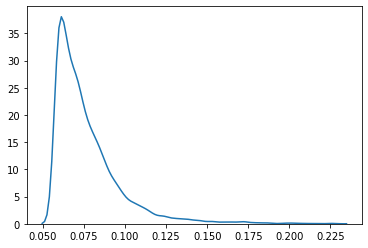

In [12]:
# get non-zero injected links
indexes = injection_final.nonzero()
index_arr = np.stack(indexes)
values = injection_final[indexes]

# sort injected links
sorted_idx = np.flip(np.argsort(values))

sorted_index = index_arr[:, sorted_idx]
sorted_values = values[sorted_idx]

# get the largest N out
num_edges = data.edge_index.size(1)
pred_index = sorted_index[:, :num_edges].T
pred_values = sorted_values[:num_edges]
print(pred_index)
print(pred_values)
print(pred_index.shape)
print(pred_values.shape)

sns.distplot(pred_values, hist=False)
plt.show()

In [14]:
true_index = data.edge_index.cpu().numpy().T

start = true_index[:, 0]

unq_val, unq_idx = np.unique(start, return_index=True)
start_dict = dict(zip(unq_val, unq_idx))

In [15]:
correct_list = []
for i in range(len(pred_index)):
    pred = pred_index[i]
    if pred[0] in start_dict:
        begin = start_dict[pred[0]]
        if pred[0] + 1 in start_dict:
            end = start_dict[pred[0] + 1]
        else:
            end = len(true_index)
    for j in range(begin, end):
        true = true_index[j]
        if np.array_equal(pred, true):
            print(i, j, pred, true)
            correct_list.append((i, pred))
            break

273 383 [ 90 155] [ 90 155]
1195 6797 [1701 1872] [1701 1872]
1238 706 [155  90] [155  90]
1988 6731 [1701  143] [1701  143]
4042 7197 [1777  426] [1777  426]
5475 2871 [ 720 1441] [ 720 1441]
5541 1457 [ 354 1803] [ 354 1803]
6017 543 [ 118 1507] [ 118 1507]
6739 8498 [2054 1602] [2054 1602]
7076 10258 [2561 2560] [2561 2560]
8087 7256 [1789  426] [1789  426]
9161 6752 [1701  664] [1701  664]
9296 6442 [1624 1777] [1624 1777]
9612 6050 [1528 1361] [1528 1361]
10315 7687 [1894 1215] [1894 1215]


In [20]:
hit_rates = np.array([0.0014209928003031452,])

hit_rate = len(correct_list) / num_edges
print('hits =', len(correct_list))
print('hit rate =', hit_rate)
print('average hit rate = %.4f %%' % (np.mean(hit_rates) * 100))
print('number of top-scored predictions =', len(pred_index))
print('number of edges in the graph =', len(true_index))
num_options = len(true_index) ** 2
print('p =', 1 / num_options)
print('significance =', hit_rate * num_options)

hits = 15
hit rate = 0.0014209928003031452
average hit rate = 0.1421 %
number of top-scored predictions = 10556
number of edges in the graph = 10556
p = 8.974313504503885e-09
significance = 158340.0


In [17]:
MR_list = np.array([5737.0,])

MR = np.mean(np.array([item[0] for item in correct_list]))
print('MR =', MR)
print('MR Ratio =', 1 - MR / num_edges)

MR = 5737.0
MR Ratio = 0.45651762031072374
